In [ ]:
# Execute the common model notebook
%run common_model.ipynb

# Create the model with constraints and objective
mdl, produccion_vars, products = create_model()

# Solve the model
solve_model(mdl)


Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 12800
* Total benefit=12800
Production of A: 0
Production of B: 80.0
Production of C: 320.0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results
rhs_values = []
objective_values = []

real_rhs_value = 0

m = 0.01


In [ ]:
# Perform sensitivity analysis of the RHS
### Aux: misma función que VM
def perform_sensitivity_analysis():
    lp = LinearRelaxer.make_relaxed_model(mdl)
    lp.solve()
    cpx = lp.get_engine().get_cplex()

    return cpx.solution.sensitivity.rhs()


In [ ]:
# Adjust RHS and solve 
### Aux: misma función que VM

def solve(c, rhs_value):
    print("---")
    print("- Adjusting RHS to: {0}".format(rhs_value))
    c.rhs = rhs_value
    solution = mdl.solve()
    
    if solution is not None:       
        print("* Production model solved with objective: {:g}".format(solution.objective_value))
        print("* Total benefit=%g" % solution.objective_value)
        for p in products:
            print("Production of {product}: {prod_var}".format(product=p[0], prod_var=produccion_vars[p].solution_value))
        return solution
    else:
        print("No solution found for RHS value: {0}".format(rhs_value))
        return None  # Return None to indicate that the model is infeasible at this point
    

In [ ]:
# Report values for the chart
### Aux: misma función que VM (cambian las listas nomás)

def report(rhs_value, obj):
    rhs_values.append(rhs_value)
    objective_values.append(obj)
    

In [ ]:
# Iterate over RHS (from 0 to infinity) starting from current RHS value

def iterate_over_rhs(constraint_name):
    c = mdl.get_constraint_by_name(constraint_name)
    if c is None:
        print("Constraint with name '{0}' not found.".format(constraint_name))
        return
        
    # Perform initial sensitivity analysis to get the starting lower and upper bounds
    initial_sensitivity = perform_sensitivity_analysis()
    
    # Find the sensitivity range for the specified constraint
    for c_sens, (lower, upper) in zip(mdl.iter_constraints(), initial_sensitivity):
        if c_sens.name == constraint_name:
            
            # Report the real RHS value for the chart
            global real_rhs_value #use the global keyword to declare that you want the function to update the global variable
            real_rhs_value = c_sens.rhs.constant
            report(real_rhs_value, mdl.objective_value)
        
            # *********Store and report the initial lower and upper bounds for the chart*********
            print("---Initial lower bound: {0}".format(lower))
            rhs = lower
            solution = solve(c, rhs)
            if solution is not None:
                report(rhs, mdl.objective_value)

            print("---Initial upper bound: {0}".format(upper))
            rhs = upper
            solution = solve(c, rhs)
            if solution is not None and rhs < mdl.infinity:
                report(rhs, mdl.objective_value)
            # ********* End of lower and upper bounds *********
            
            
            #Decrease rhs starting from lower bound - m
            rhs = lower - m
            while True:
                if rhs < 0:
                    break ## Stop if the rhs is lower than 0                
                
                solution = solve(c, rhs)#+m) # aux: no son escalones, un "m" afecta al Z # TEMP # Da Timeout
                                        # claro, siempre obtengo el mismo rango xq me quedé en el inicial si
                                        # le vuevo a sumar el m que le resté, #ja.
                if solution is None:
                    break  # Stop if the model is infeasible
                
                #report(c_sens.rhs.constant+m, mdl.objective_value) ### AUX PROBANDO
                # Perform sensitivity analysis to get the new lower bound
                new_sensitivity = perform_sensitivity_analysis()                
                for c_new_sens, (new_lower, _) in zip(mdl.iter_constraints(), new_sensitivity):
                    if c_new_sens.name == constraint_name: 
                        rhs = new_lower
                        if rhs < 0:
                            break ## Stop if the rhs is lower than 0                
                            
                        solution = solve(c, rhs)
                        if solution is None:
                            break  # Stop if the model is infeasible
                        report(c_new_sens.rhs.constant, mdl.objective_value)
                        
                        rhs = new_lower - m

                        break


            # Increase rhs starting from upper bound + m
            rhs = upper + m
            
            while True:
                if rhs >= mdl.infinity:
                    break ## Stop if the rhs reaches or exceeds infinity

                solution = solve(c, rhs)#-m) # aux: no son escalones, un "m" afecta al Z # TEMP
                if solution is None:
                    break  # Stop if the model is infeasible

                #report(c_sens.rhs.constant-m, mdl.objective_value) ### AUX PROBANDO
                # Perform sensitivity analysis to get the new upper bound
                new_sensitivity = perform_sensitivity_analysis()
                for c_new_sens, (_, new_upper) in zip(mdl.iter_constraints(), new_sensitivity):
                    if c_new_sens.name == constraint_name:                        
                        rhs = new_upper
                        if rhs >= mdl.infinity:
                            break ## Stop if the rhs reaches or exceeds infinity

                        solution = solve(c, rhs)
                        if solution is None:
                            break  # Stop if the model is infeasible
                        report(c_new_sens.rhs.constant, mdl.objective_value)
                        
                        rhs = new_upper + m

                        break
                        

In [ ]:
# Usage of the iterate_over_rhs method
constraint_name = 'Disp_Equipo3'  # The name of the constraint to analyze
iterate_over_rhs(constraint_name)


---Initial lower bound: 272.0
---
- Adjusting RHS to: 272.0
* Production model solved with objective: 12800
* Total benefit=12800
Production of A: 0
Production of B: 80.0
Production of C: 320.0
---Initial upper bound: 1e+20
---
- Adjusting RHS to: 1e+20
* Production model solved with objective: 12800
* Total benefit=12800
Production of A: 0
Production of B: 80.0
Production of C: 320.0
---
- Adjusting RHS to: 271.99
* Production model solved with objective: 12799.7
* Total benefit=12799.7
Production of A: 0.010000000000005116
Production of B: 80.0
Production of C: 319.97333333333336
---
- Adjusting RHS to: 172.0
* Production model solved with objective: 9800
* Total benefit=9800
Production of A: 100.0
Production of B: 80.0
Production of C: 53.33333333333333
---
- Adjusting RHS to: 171.99
* Production model solved with objective: 9799.5
* Total benefit=9799.5
Production of A: 100.0
Production of B: 80.0
Production of C: 53.31666666666669
---
- Adjusting RHS to: 140.0
* Production model s

In [ ]:
### Mejora1
# Armo pares y los ordeno según 'x'
pairs = []
for i in range(len(rhs_values)):
    pairs.append((rhs_values[i], objective_values[i]))

print("pairs", pairs)

#pairs.sort()
# Ordeno ascendentemente por la primera componente y Asc por la segunda si hay empates
pairs.sort(key=lambda x: (x[0], x[1]))

print("pairs", pairs)

# Los vuelvo a separar en listas, para no cambiar la función plot
new_rhs, new_obj = [], []
for elem in pairs:
    new_rhs.append(elem[0])
    new_obj.append(elem[1])
print("new_rhs", new_rhs)
print("new_dual", new_obj)

pairs [(300, 12800.0), (272.0, 12800.0), (172.0, 9800.0), (140.0, 8200.0), (80.0, 3200.0)]
pairs [(80.0, 3200.0), (140.0, 8200.0), (172.0, 9800.0), (272.0, 12800.0), (300, 12800.0)]
new_rhs [80.0, 140.0, 172.0, 272.0, 300]
new_dual [3200.0, 8200.0, 9800.0, 12800.0, 12800.0]


In [ ]:
# Plot the chart: objective vs. rhs value

import matplotlib.pyplot as plt
import matplotlib

# Optional: xunit: unit to plot for x-axis
# Optional: yunit: unit to plot for y-axis
def plot(xunit, yunit, rhs_values, objective_values):

    # Set default font size for all text elements
    matplotlib.rcParams.update({'font.size': 18})
    
    plt.plot(rhs_values, objective_values, marker='o', linewidth=3)
    
    # Set the x-axis and y-axis ticks to the values we are printing
    plt.xticks(rhs_values)
    plt.yticks(objective_values)

    #Print current real value
    plt.axvline(x=real_rhs_value, color='g', linestyle='--', label='Valor actual')
    
    plt.xlabel('{0}\n{1}'.format(constraint_name, xunit), labelpad=20, color='#DC143C')
    plt.ylabel('Funcional\n{}'.format(yunit), rotation=0, labelpad=50, color='#DC143C')
    plt.title('Funcional vs. {}'.format(constraint_name), pad=30)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.2, color='gray', alpha=0.7)

    # Extender el último rango un poco hacia la derecha
    x_start = rhs_values[-1] # Punto donde comienza la línea
    # aux: ^ debería ser max(eso, el_rhs_actual)
    x_offset = 20
    y_value = objective_values[-1]
    plt.hlines(y=y_value, xmin=x_start, xmax=x_start + x_offset, color='C0', linewidth=3) #6)

    
    plt.show()
    

In [ ]:
### AUX
print(rhs_values)
print(objective_values)

[300, 272.0, 172.0, 140.0, 80.0]
[12800.0, 12800.0, 9800.0, 8200.0, 3200.0]


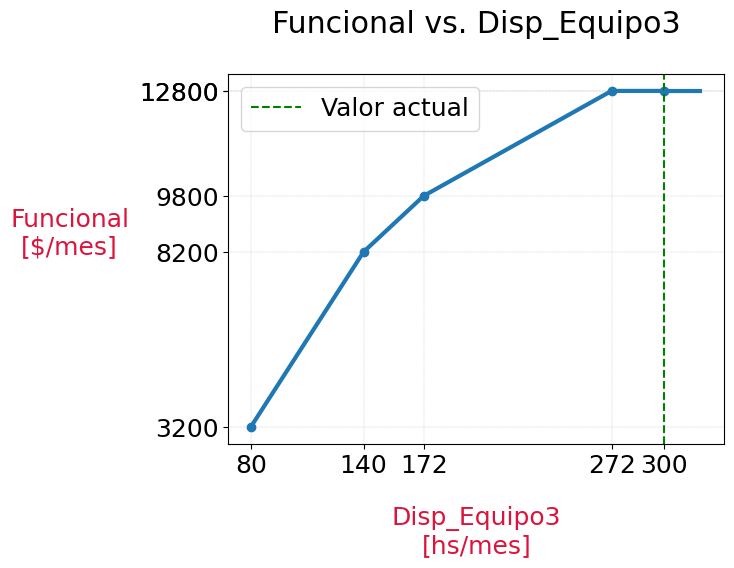

In [ ]:
# Usage of pLot the chart
plot("[hs/mes]", "[$/mes]", new_rhs, new_obj)